In [85]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import math

In [86]:
training_data = datasets.FashionMNIST(
    root="data", # the root directory to save the downloaded dataset
    train=True, # choose whether it is test or train
    download=True, # choose whether to download the dataset or not 
    transform=ToTensor() # what transforms should be applied to the dataset, in this case it just 
                         # converts the images to torch.tensor
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

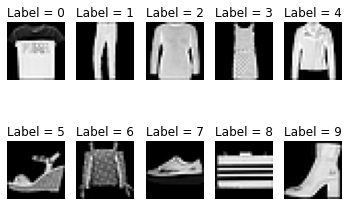

In [87]:
L = []
lab = []
for j in range(10):
    while j not in lab:
        for i in range(random.randint(0, len(training_data)), len(training_data)):
            if j not in lab:
                if training_data[i][1]==j:
                    im = training_data[i][0]
                    im1 = torch.reshape(im, (28,28))
                    L.append(im1)
                    lab.append(j)
t=0
for i in range(10):
    for t in range(10):
        if(lab[i]==t):
            plt.subplot(2, 5, t+1)
            plt.imshow(L[i], cmap="gray")
            plt.title(f"Label = {lab[i]}")
            plt.axis(False)
plt.show()

In [88]:
training_data = datasets.FashionMNIST(
    root="data", # the root directory to save the downloaded dataset
    train=True, # choose whether it is test or train
    download=True, # choose whether to download the dataset or not 
    transform=ToTensor(), # what transforms should be applied to the dataset, in this case it just 
                         # converts the images to torch.tensor
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),
                                                                                    value=1))
)

In [118]:
learning_rate = 8e-2
batch_size = 32
epochs = 20

In [119]:
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

In [120]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [121]:
def myReLU(x):
    x[x<=0] = 0.
    return x

def mysoftMax(x):
    return torch.exp(x/10000000)/torch.sum(torch.exp(x/10000000))

def CEL(y,pred):
    cel = -torch.sum(torch.mul(y,torch.log2(pred)))
    return cel

In [122]:
def model(X, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
    x1 = myReLU(torch.matmul(X,W1)+b1)
    x2 = myReLU(torch.matmul(x1,W2)+b2)
    x3 = myReLU(torch.matmul(x2,W3)+b3)
    x4 = myReLU(torch.matmul(x3,W4)+b4)
    x5 = mysoftMax(torch.matmul(x4,W5)+b5)
    return x5

def train_loop(dataloader, model, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5, learning_rate):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        loss = 0
        for i in range(len(X)):
            pred = model(torch.reshape(X[i], (1, 784)), W1, W2, W3, W4, W5, b1, b2, b3, b4, b5)
            loss += CEL(y[i], pred)
        
        loss.backward()
        with torch.no_grad(): 
            W1 -= learning_rate * W1.grad/torch.norm(W1.grad)
            b1 -= learning_rate * b1.grad/torch.norm(b1.grad)
            W2 -= learning_rate * W2.grad/torch.norm(W2.grad)
            b2 -= learning_rate * b2.grad/torch.norm(b2.grad)
            W3 -= learning_rate * W3.grad/torch.norm(W3.grad)
            b3 -= learning_rate * b3.grad/torch.norm(b3.grad)
            W4 -= learning_rate * W4.grad/torch.norm(W4.grad)
            b4 -= learning_rate * b4.grad/torch.norm(b4.grad)
            W5 -= learning_rate * W5.grad/torch.norm(W5.grad)
            b5 -= learning_rate * b5.grad/torch.norm(b5.grad)
            W1.grad.zero_()
            b1.grad.zero_()
            W2.grad.zero_()
            b2.grad.zero_()
            W3.grad.zero_()
            b3.grad.zero_()
            W4.grad.zero_()
            b4.grad.zero_()
            W5.grad.zero_()
            b5.grad.zero_()   
        
        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return W1, W2, W3, W4, W5, b1, b2, b3, b4, b5

def test_loop(dataloader, model, W1, W2, W3, W4, W5, b1, b2, b3, b4, b5):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0., 0.

    
    
    with torch.no_grad():
        for X, y in dataloader:
            for i in range(len(X)):
                pred = model(torch.reshape(X[i], (1, 784)), W1, W2, W3, W4, W5, b1, b2, b3, b4, b5)
                test_loss += CEL(y[i], pred)
                correct += (pred.argmax() == y[i].argmax()).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


W1 = torch.randn(784, 512, requires_grad=True)
b1 = torch.randn(1, 512, requires_grad=True)

W2 = torch.randn(512, 256, requires_grad=True)
b2 = torch.randn(1, 256, requires_grad=True)

W3 = torch.randn(256, 64, requires_grad=True)
b3 = torch.randn(1, 64, requires_grad=True)

W4 = torch.randn(64, 32, requires_grad=True)
b4 = torch.randn(1, 32, requires_grad=True)

W5 = torch.randn(32, 10, requires_grad=True)
b5 = torch.randn(1, 10, requires_grad=True)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    W11, W21, W31, W41, W51, b11, b21, b31, b41, b51=train_loop(train_dataloader, model,
                                                      W1, W2, W3, W4, W5, b1, b2, b3, b4, b5,
                                                      learning_rate)
    
    test_loop(test_dataloader, model, W11, W21, W31, W41, W51, b11, b21, b31, b41, b51)
    W1, W2, W3, W4, W5, b1, b2, b3, b4, b5 = W11, W21, W31, W41, W51, b11, b21, b31, b41, b51
print("Done!")

Epoch 1
-------------------------------
loss: 106.243744  [    0/60000]
loss: 50.245598  [32000/60000]
Test Error: 
 Accuracy: 58.1%, Avg loss: 48.270172 

Epoch 2
-------------------------------
loss: 40.389828  [    0/60000]
loss: 42.786469  [32000/60000]
Test Error: 
 Accuracy: 62.3%, Avg loss: 41.659256 

Epoch 3
-------------------------------
loss: 48.642330  [    0/60000]
loss: 26.358471  [32000/60000]
Test Error: 
 Accuracy: 69.5%, Avg loss: 37.920837 

Epoch 4
-------------------------------
loss: 32.362122  [    0/60000]
loss: 50.389343  [32000/60000]
Test Error: 
 Accuracy: 71.9%, Avg loss: 35.104748 

Epoch 5
-------------------------------
loss: 35.498676  [    0/60000]
loss: 19.981527  [32000/60000]
Test Error: 
 Accuracy: 73.3%, Avg loss: 33.521149 

Epoch 6
-------------------------------
loss: 28.006672  [    0/60000]
loss: 32.590385  [32000/60000]
Test Error: 
 Accuracy: 73.6%, Avg loss: 32.973175 

Epoch 7
-------------------------------
loss: 59.798271  [    0/60000

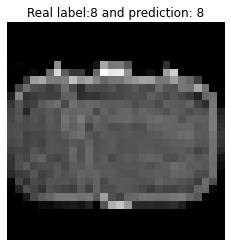

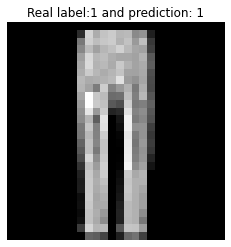

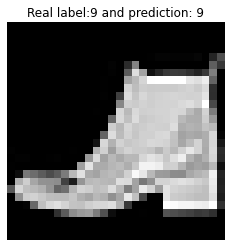

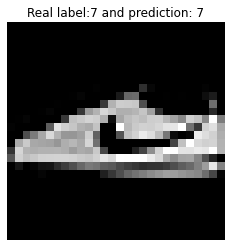

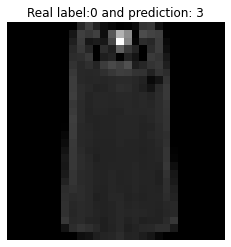

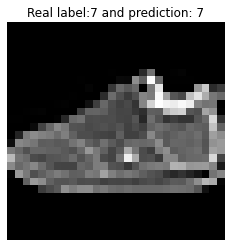

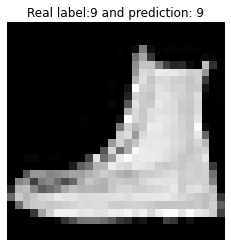

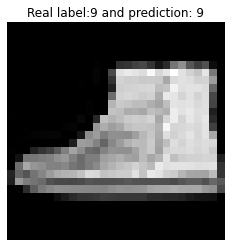

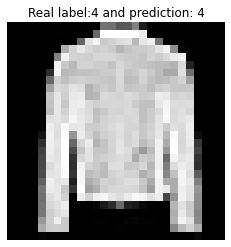

In [140]:
imgs = []
Real = []
Pred = []
for j in range(9):
    i =random.randint(0, len(test_data))
    im1 = test_data[i][0]
    real_label = test_data[i][1]
    Real.append(torch.argmax(real_label))
    prediction =torch.argmax(model(torch.reshape(test_data[i][0],(1,784)),W1,W2,W3,W4,W5,b1,b2,b3,b4,b5))
    imgs.append(im1)
    Pred.append(prediction)
    
t=0
for i in range(9):
    plt.imshow(imgs[i].squeeze(), cmap="gray")
    plt.title(f"Real label:{Real[i].item()} and prediction: {Pred[i].item()}")
    plt.axis(False)
    t+=1
    plt.show()